In [47]:
# Setup feedback system
import learntools
from learntools.core import binder
binder.bind(globals())
#from learntools.time_series.ex3 import *

# Setup notebook
from pathlib import Path
#from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_periodogram, seasonal_plot

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [59]:


store_sales = pd.read_csv(
    'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
)

average_2017_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

C:\Users\Anonymous\AppData\Local\Temp\ipykernel_35844\1703030817.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(


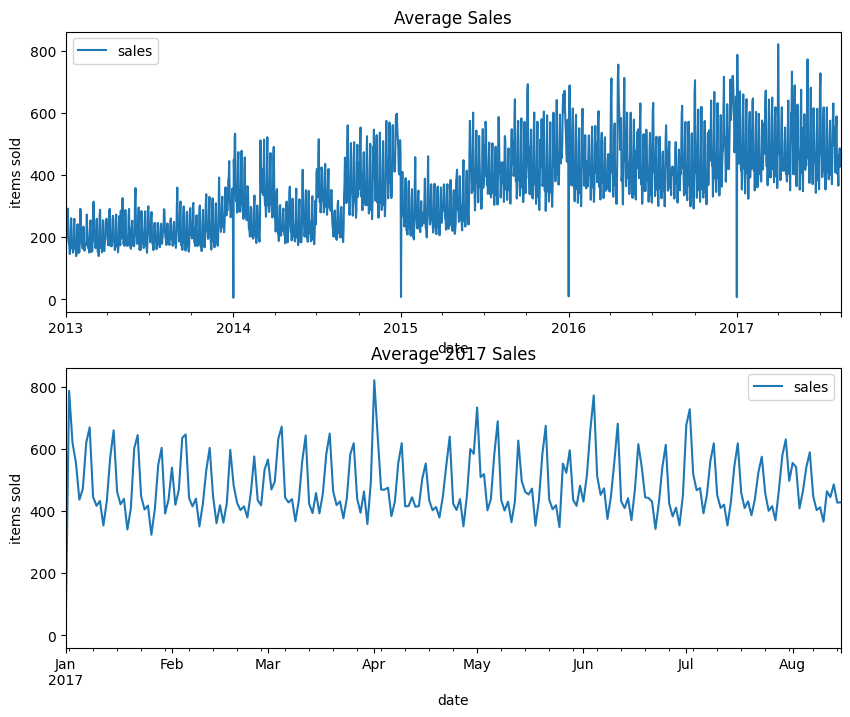

In [64]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharey=True)

X = average_sales.to_frame()
ax = X.plot(ax=ax1, title="Average Sales", ylabel="items sold")
ax.legend();

X = average_2017_sales.to_frame()
ax = X.plot(ax=ax2, title="Average 2017 Sales", ylabel="items sold")
ax.legend();

- There is a general trend in the yearly data
- Using the latest year to visualize seasonality
- Within the yearly trend there seems to be seasonality

<Axes: title={'center': 'Rolling 2017 sales'}, xlabel='date'>

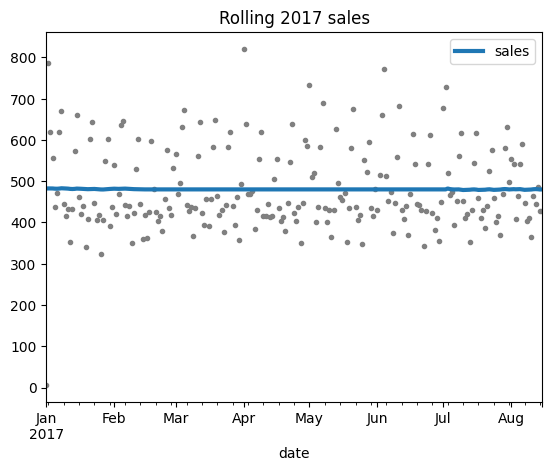

In [73]:
trend = average_2017_sales.rolling(
    window=365,
    center=True,
    min_periods=128
).mean()

X_detrend = average_2017_sales - trend


ax = average_2017_sales.plot(style=".", color="0.5")
trend.plot(ax=ax, linewidth=3, legend=True, title="Rolling 2017 sales")

There isn't a trend in the yearly data

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

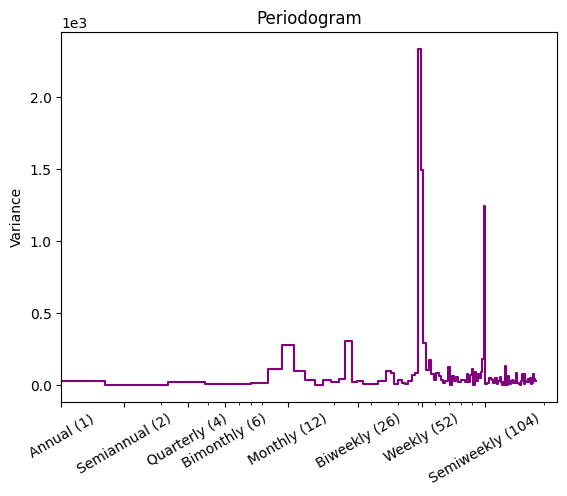

In [75]:
plot_periodogram(average_2017_sales)

The periodgram shows mostly biweekly and weekly seasonality with hints of monthly seasonality.

c:\Python311\Lib\site-packages\learntools-0.3.4-py3.11.egg\learntools\time_series\utils.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

c:\Python311\Lib\site-packages\learntools-0.3.4-py3.11.egg\learntools\time_series\utils.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

c:\Python311\Lib\site-packages\learntools-0.3.4-py3.11.egg\learntools\time_series\utils.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.



<Axes: title={'center': 'Seasonal Plot (month/day)'}, xlabel='day', ylabel='sales'>

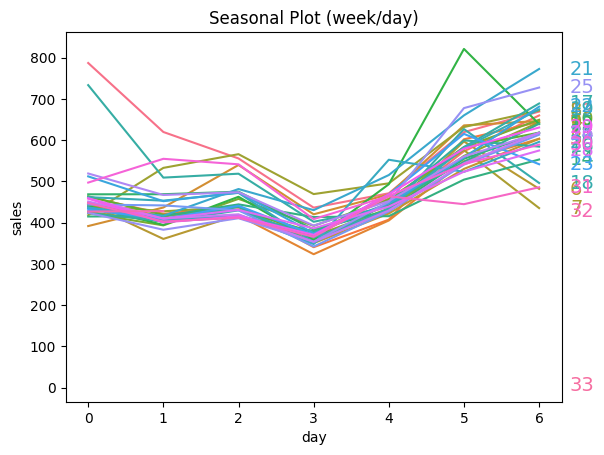

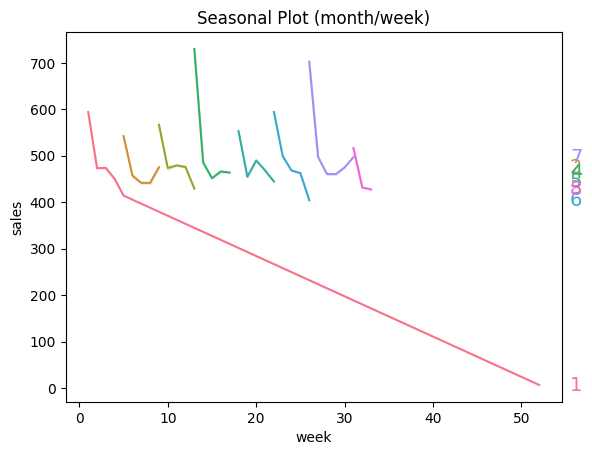

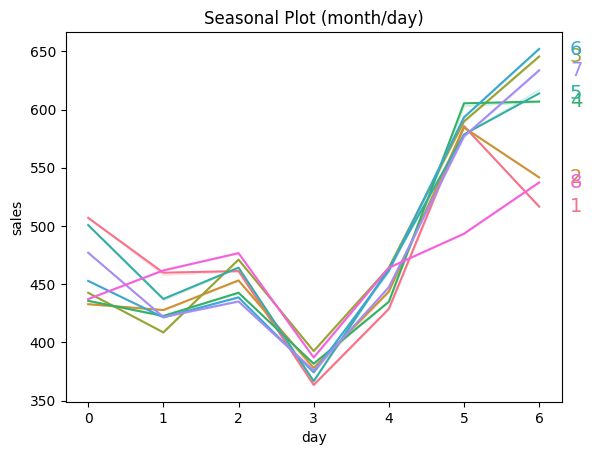

In [77]:
X = average_2017_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
X["month"] = X.index.month
seasonal_plot(X, y="sales", period="week", freq="day")
seasonal_plot(X, y="sales", period="month", freq="week")
seasonal_plot(X, y="sales", period="month", freq="day")

The most uniform seasonality is the Weekly seasonality. There isn't an easy way to break down the biweekly seasonality to check that.

In [78]:
y = average_2017_sales.copy()

# Quarterly seasonality
fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
    order=1,
)

X = dp.in_sample()


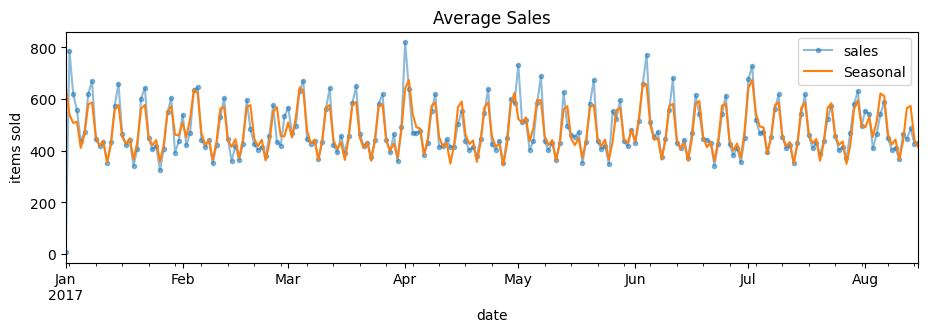

In [82]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(marker=".", alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal", figsize=(11, 3))
ax.legend();

Text(0.5, 1.0, 'Periodogram of Deseasoned Sales')

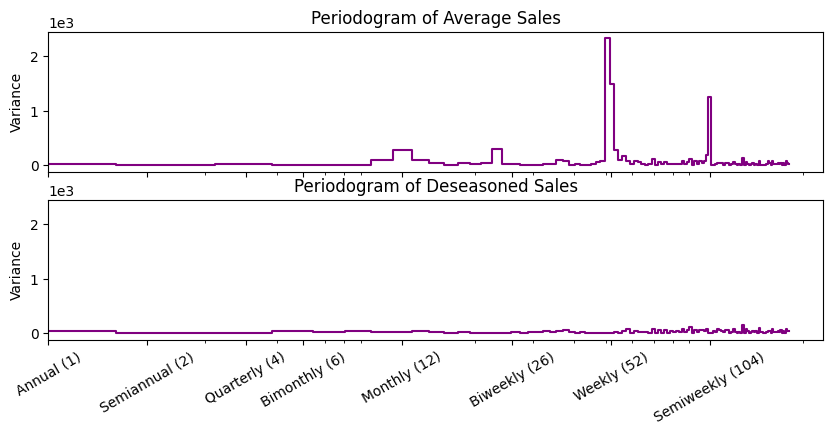

In [88]:
deseasoned = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4), sharex=True, sharey=True)
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Periodogram of Average Sales")

ax2 = plot_periodogram(deseasoned, ax=ax2)
ax2.set_title("Periodogram of Deseasoned Sales")


Seasonality seems to be modeled well

In [ ]:
# National and regional holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)